# [...] ducc

In this notebook, we present a <a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">ducc</a>-based pipeline to simulate time-ordered data (TOD) for:
1) an experiment with a LiteBIRD-like scanning strategy;
2) offset detectors (not at boresight);
3) a noise component;
4) a dipole component.

Each of these functionalities is discussed in the corresponding (numbered) section.

## 1) LiteBIRD-like scanning strategy

We have written a slightly modified version of beamconv's <code>scanning.py</code> module (<code>scanning_mod.py</code>) that allows to simulate a LiteBIRD-like scanning strategy. The <code>scanning.py</code> module is based on the <a href="https://github.com/tmatsumu/LB_SYSPL_v4.2">pyScan</a> code written by Tomotake Matsumura (IPMU).

Here we show how to use it.

#### Setting things up
First, we need to import a few modules and define some useful functions for plotting.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import time

import pysm3
import pysm3.units as u

import ducc0
import mueller_convolver
import scanning_mod as scanning

#TODO: eventually delete the next two lines
#from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma')
new_cmap = truncate_colormap(cmap, 0.2, 1)

#### Preparing input maps
We generate I, Q and U input maps from some pysm sky model.

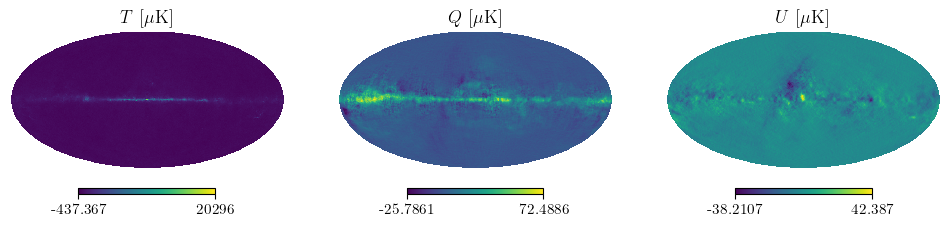

In [2]:
nside = 128
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm = hp.map2alm(maps_pysm, lmax=lmax)
maps = hp.alm2map(slm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

#### Setting up ducc

First, we define a simple Gaussian beam to scan the sky. More complex beams can be fed to the code as $b_{\ell m}$ spherical harmonic coefficients.

In [3]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

def get_gauss_beam_from_beamconv(fwhm, lmax):
    import beamconv
    blmT, blmm2 = beamconv.tools.gauss_blm(fwhm*180*60/np.pi, lmax, pol=True)
    res = np.zeros((4,blmT.shape[0]), dtype=np.complex128)
    blmE, blmB = beamconv.tools.spin2eb(blmm2, blmm2*0, spin=2)
    res[0] = blmT
    res[1] = blmE
    res[2] = blmB
    res[3] = blmT  # correct?
    return res

def blm_gauss_new(fwhm, lmax, pol=False):
    fwhm = float(fwhm)
    lmax = int(lmax)
    pol = bool(pol)
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = np.exp(-0.5*sigmasq*l*(l+1))

    if pol:
        for l in range(2, lmax+1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = np.exp(-0.5 * sigmasq * (l*(l+1)-4))
        blm[2] = 1j * blm[1]

    return blm

# blm_gauss_new times sqrt((2*l+1)/(4pi))
def Blm_gauss_new(fwhm, lmax, pol=False):
    blm = blm_gauss_new(fwhm, lmax, pol)
    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] *= np.sqrt((2*l+1) / (4*np.pi))

    if pol:
        for l in range(2, lmax+1):
            blm[1:3, hp.Alm.getidx(lmax, l, 2)] *= np.sqrt((2*l+1) / (4*np.pi))

    return blm

In [4]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
lmax = 30
kmax = 18

In [5]:
fwhm_arcmin = 5
fwhm_rad = np.radians(fwhm_arcmin/60)

# completely random beam
blm = make_full_random_alm(lmax, kmax, rng)
# ... or use a Gauss beam
#blmtmp = blm_gauss_new(fwhm_rad, lmax, True)
#blm *= 0
#blm [0:3, 0:blmtmp.shape[1]] = blmtmp

In [6]:
# completely random sky
slm =make_full_random_alm(lmax, lmax, rng)

#### Running ducc (external pointings)

We specify the scanning strategy by directly providing the pointings.

In [27]:
ctim0 = 1510000000                   # initial time

duration = 3600*24*7                  # mission duration in s (7 days)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

In [48]:
fquat = 1.
nquat = int(duration*fquat)

ctime_quat = ctim0 + np.arange(nquat)/fquat
theta, phi, psi = scanning.ctime2bore(ctime_quat)

ptg = np.empty((nquat,3))
ptg[:,0] = theta
ptg[:,1] = phi
ptg[:,2] = psi

In [49]:
#THE NEXT CELL SHOULD BE DONE WITH DUCC

In [53]:
Q = qp.QPoint()

# From (theta,phi) to (ra,dec) convention
# Also, all angles are converted in degrees
ra = np.degrees(phi) - 180.
dec = np.degrees(theta) - 90.
psi = np.degrees(psi)

# Calculate the quaternion
q_bore = Q.radecpa2quat(ra, dec, psi)

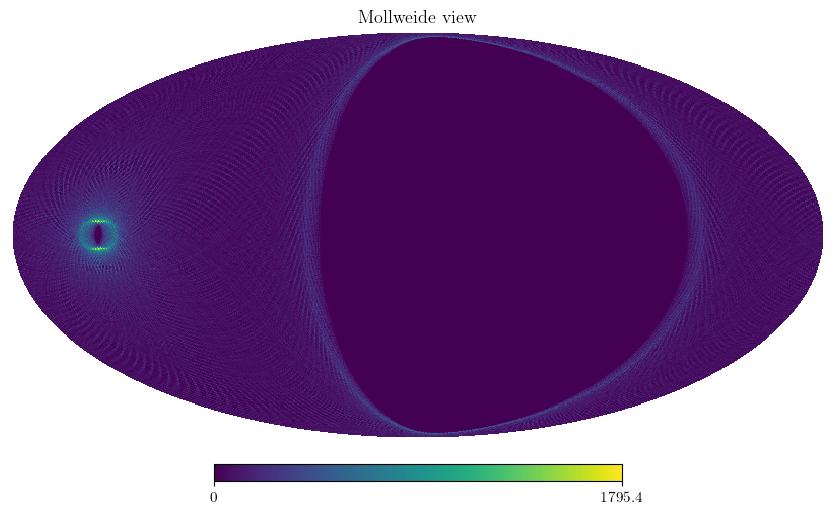

In [56]:
#TODO: avoid for loop
pixs = hp.ang2pix(128, theta, phi+np.pi) #FIXME: I HAD TO ADD np.pi TO MAKE THE MAP THE SAME AS BEAMCONV!

hits = np.empty(12*128**2)

for p in np.arange(12*128**2):
    hits[p] = np.count_nonzero(pixs == p)
        
hp.mollview(hits)
plt.show()

In [37]:
off_quat = np.array([0.009165646421980997, 0.09071095143135842, 0.0, 0.9958350838447524])

nsamp_new = nsamp #full duration!

new_quats = np.empty((nsamp_new,4))

pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fquat, quat=q_bore, nthreads=1)
rotated_pointings = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=False, out=new_quats)

In [38]:
print(rotated_pointings)

[[-0.66076461  0.43051763  0.05421499  0.61245852]
 [-0.66071909  0.43043592  0.05418275  0.6125679 ]
 [-0.66067356  0.4303542   0.05415051  0.61267727]
 ...
 [ 0.40462734  0.72040953  0.08412037 -0.55696552]
 [ 0.40456075  0.72047     0.08422779 -0.55691943]
 [ 0.40449415  0.72053046  0.08433521 -0.55687334]]


In [39]:
temp_ptg = Q.quat2radecpa(rotated_pointings)

print(np.shape(temp_ptg))

ptg = np.empty((nsamp_new,3))

# From (ra,dec) to (theta,phi) convention
# Also, all angles are converted in radians
ptg[:,0] = scanning.wraparound_npi(np.radians(temp_ptg[0] + 180),1)
ptg[:,1] = scanning.wraparound_npi(np.radians(temp_ptg[1] + 90),2)
ptg[:,2] = np.radians(temp_ptg[2])

(3, 11551680)


In [40]:
# completely random Mueller matrix
mueller = np.random.uniform(-1,1,size=(4,4))
#mueller[1:3,0]=mueller[1:3,-1] = 0
#mueller[0,2]=mueller[2,0] = 0

#TODO: write something reasonable
hwp_angles = np.random.uniform(0,2*np.pi,size=(nsamp_new,))  # alpha

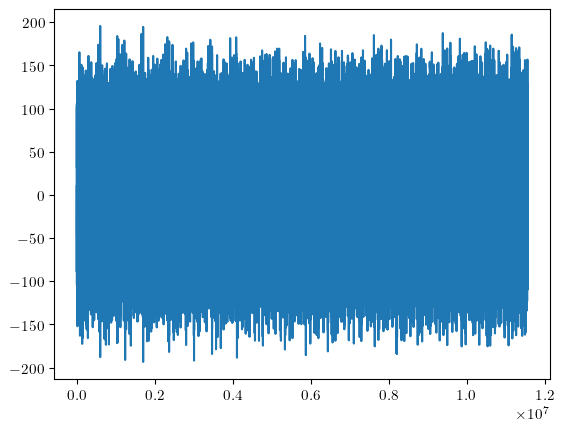

7.033972501754761


In [42]:
start = time.time()

# Now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)


plt.plot(signal_muellerconvolver, label="MuellerConvolver")
#plt.legend()
plt.show()

print(time.time()-start)

We run ducc with those specifics and plot the hitmap.

In [21]:
# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
psi = np.degrees(ptg[:,2])

# calculate the quaternion
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def ctime_test(**kwargs):
    return ctime0 + t_samp_array[kwargs.pop('start'):kwargs.pop('end')]

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.add_to_focal_plane(single_beam, combine=False)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.title('hits for external pointings (on detector at boresight)')
plt.savefig('proj_ptg.pdf')

del(S_ptg, cond, proj)

NameError: name 'ScanStrategy' is not defined

#### Running beamconv (LiteBIRD-like scanning strategy)

We re-run beamconv (<code>scan_instrument_mpi</code>) with a LiteBIRD-like scanning strategy by setting <code>use_l2_scan=True</code>.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan


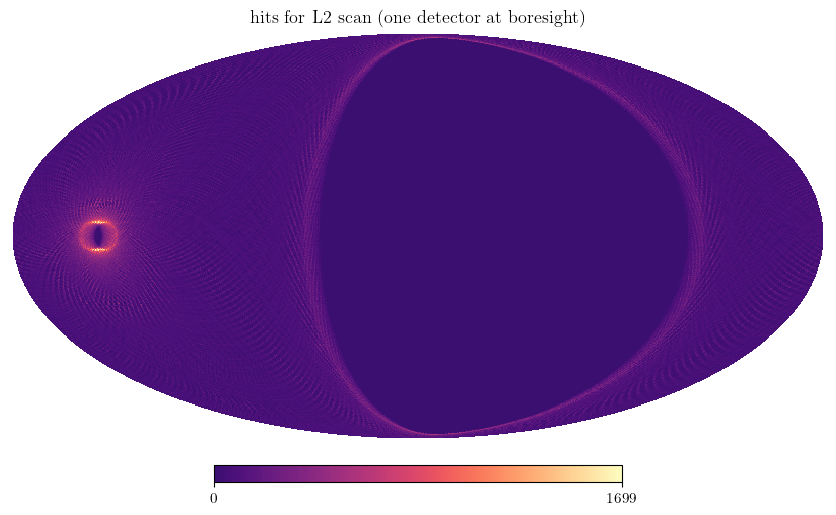

In [6]:
start = time.time()
S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctime0)
S_L2.add_to_focal_plane(single_beam, combine=False)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_noiseless, cond, proj = S_L2.solve_for_map(return_proj = True)

tod_noiseless = S_L2.data(S_L2.chunks[0], beam=single_beam, data_type='tod').copy()
time_noiseless = time.time() - start

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.title('hits for L2 scan (one detector at boresight)')
plt.savefig('proj_L2.pdf')

del(S_L2, cond, proj)

Let's check the binned maps for lower resolution.

In [7]:
nside = 16
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm_16 = hp.map2alm(maps_pysm, lmax=lmax)
maps_16 = hp.alm2map(slm_16,nside=nside)

Tmin = np.min(maps_16[0])
Tmax = np.max(maps_16[0])

ndet = 2

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.array([[0,90],[45,135]])

# setting up the beam options
beam_opts_polangs = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_polangs)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm_16, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)
del(S_ptg, cond, proj)

S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctime0)
S_L2.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_polangs)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm_16, save_tod=True, use_l2_scan=True,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_L2, cond_L2, proj = S_L2.solve_for_map(return_proj = True)
del(S_L2, proj)

Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan


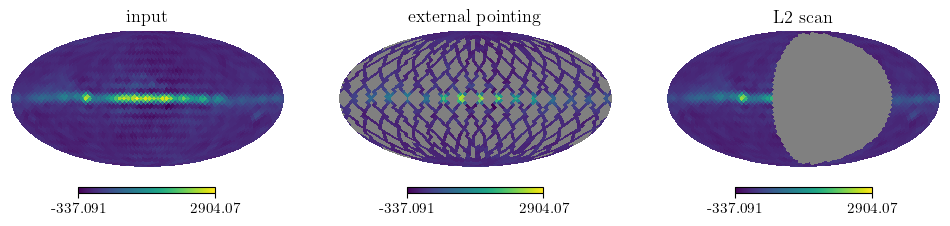

In [8]:
# plotting temperature maps
fwhm_rad = fwhm_arcmin/60/180*np.pi
smoothed_maps = hp.sphtfunc.smoothing(maps_16, fwhm=fwhm_rad)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(smoothed_maps[0], title=r'input', hold=True, min=Tmin, max=Tmax)
plt.axes(ax2)
hp.mollview(out_maps_ptg[0], title=r'external pointing', hold=True, min=Tmin, max=Tmax)
plt.axes(ax3)
hp.mollview(out_maps_L2[0], title=r'L2 scan', hold=True, min=Tmin, max=Tmax)
plt.show()

## 2) Reading detector offset quaternions

Another functionality that we added to beamconv is the possibility to feed detector offset quaternions to the
<code>input_focal_plane</code> function. This allows to account for the specific location of the detectors on the focal plane.

Here we show an example of this functionality. Note the difference between the resulting hits map and the one with a single detector at boresight.

Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan


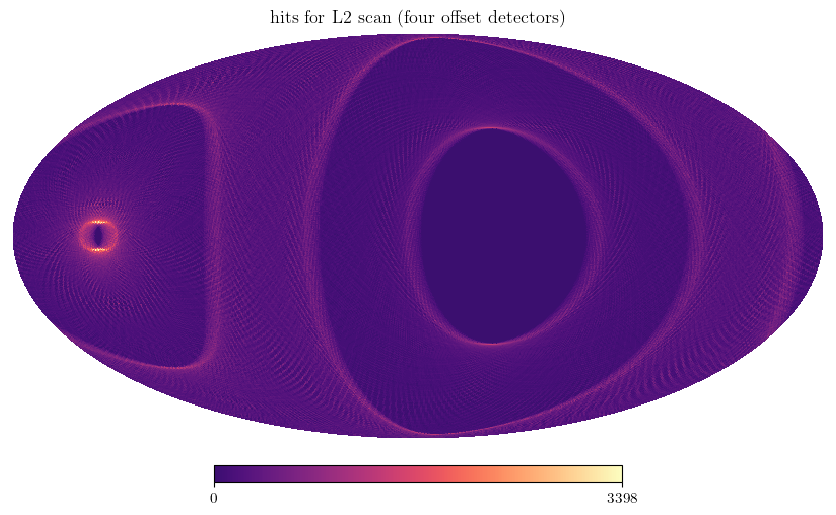

In [9]:
nside = 128 # had to define explicitly
lmax = 2*nside

ndet = 2
quats = np.zeros((2,2,4))
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[0,1,:] = np.array([0.009165646421980997, 0.09071095143135842, 0.0, 0.9958350838447524])
quats[1,0,:] = np.array([0.03704627596838304, 0.08283588163313664, 0.3811046277509462, 0.9200679609994841])
quats[1,1,:] = np.array([0.05236230340491963, 0.08463363396964103, 0.0, 0.9950353446904406])

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))

# setting up the beam options
beam_opts_quats = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin,
                 quats=quats)

S_quats = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctime0)
S_quats.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_quats)
S_quats.allocate_maps(nside=nside)
S_quats.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True, 
                            ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_quats, cond, proj = S_quats.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.title('hits for L2 scan (four offset detectors)')
plt.savefig('proj_quats.pdf')
del(S_quats, out_maps_quats, cond, proj)

## 3) Adding a noise realization

Another new functionality implemented in the <code>LiteBIRD-like</code> branch is the possibility of adding a noise realization to the TOD, which is generated by means of the <code>OofaNoise</code> function from  <a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">ducc</a> written by Martin Reinecke (MPA).

The noise can have a white and a $1/f$ component and is described by the (frequency) power spectrum $P(f)=\sigma^2\left[\frac{f^2+f_\text{knee}^2}{f^2+f_\text{min}^2}\right]^{\frac{\alpha}{2}}$.

To generate a noisy TOD, we set <code>noise_tod=True</code> when initializing the <code>ScanStrategy</code> object and provide the necessary parameters.

In [10]:
# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
# (for a 5 days observation, the minimum observable frequency is around 1e-6 Hz)
noise_tod = True 
sigma = 100 
f_min = 1e-5 
f_knee = 0.02 
slope = -2.0

# we initialize a ScanStrategy object with noise_tod=True and the necessary noise parameters
start = time.time()
S_noisy = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctime0,
                       noise_tod=noise_tod, sigma=sigma, f_min=f_min, f_knee=f_knee, f_samp=fsamp, slope=slope)
S_noisy.add_to_focal_plane(single_beam, combine=False)
S_noisy.allocate_maps(nside=nside)
S_noisy.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                            ctime_kwargs=dict(), q_bore_kwargs=dict(),)
out_maps_noisy, cond, proj = S_noisy.solve_for_map(return_proj = True)

tod_noisy = S_noisy.data(S_noisy.chunks[0], beam=single_beam, data_type='tod').copy()
time_noisy = time.time() - start

del(S_noisy)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-11551680
Implementing L2 scan
adding noise to TOD chunk


Here we plot the first 2000 values of the noisy TOD we have just simulated, together with its noiseless counterpart.

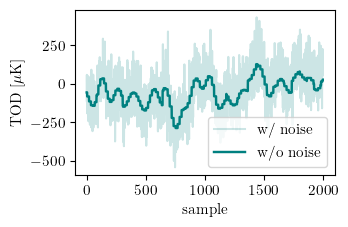

In [11]:
points=2000
color='teal'

plt.figure(figsize=(3.6, 2.4))
plt.plot(tod_noisy[:points],color=color,alpha=0.2,label='w/ noise')
plt.plot(tod_noiseless[:points],color=color,linewidth=1.75,label='w/o noise')
plt.legend()
plt.xlabel(r'sample')
plt.ylabel(r'TOD [$\mu$K]')
plt.tight_layout()
plt.savefig('noise_TOD.pdf')
plt.show()

As a countercheck, we take the difference of the noisy and noiseless TOD and check that its power spectrum tends to the theoretical one.

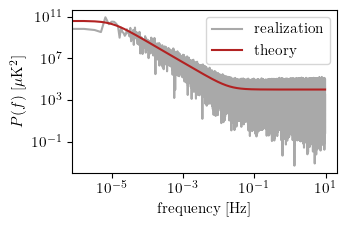

In [12]:
diff = tod_noisy - tod_noiseless

# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(diff))**2 / nsamp
time_step = 1. / fsamp
freqs = np.fft.fftfreq(diff.size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.figure(figsize=(3.6, 2.4))
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray',label='realization')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick',label='theory')
plt.legend()
plt.xlabel(r'frequency [Hz]')
plt.ylabel(r'$P(f)$ [$\mu$K$^2$]')
plt.tight_layout()
plt.savefig('noise_spectrum.pdf')
plt.show()

## 3) Adding a dipole component to the TOD
Similarly to the noise component, we have added the possibility to include a dipole component. This can generated on the fly by setting <code>dipole_tod=True</code> when itinializing the <code>ScanStrategy</code> object. What this does is to run a slightly modified version of the <code>dipole</code> module of <a href="https://github.com/litebird/litebird_sim">LiteBIRD-sim</a> framework, which returns
the dipole TOD, given the time and direction of observation. The velocity is computed
per chunk and a warning is issued whenever the chunk is too long (more than one day).

In [13]:
dipole_tod = True

# calculate TOD in 10 chunks
nchunk = 10
nsamp_chunk = int(duration*fsamp/nchunk)

start = time.time()
S_dipole = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctime0,
                        dipole_tod=dipole_tod, nu=nu*1e9)
chunks = S_dipole.partition_mission(nsamp_chunk)
S_dipole.add_to_focal_plane(single_beam, combine=False)
S_dipole.allocate_maps(nside=nside)
S_dipole.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True,
                             ctime_kwargs=dict(), q_bore_kwargs=dict(),)
out_maps_dipole, cond, proj = S_dipole.solve_for_map(return_proj = True)

tod_dipole = S_dipole.data(S_dipole.chunks[0], beam=single_beam, data_type='tod').copy()
time_dipole = time.time() - start

del(S_dipole)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1155168
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 001: samples 1155168-2310336
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 002: samples 2310336-3465504
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 003: samples 3465504-4620672
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 004: samples 4620672-5775840
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 005: samples 5775840-6931008
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 006: samples 6931008-8086176
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 007: samples 8086176-9241344
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on chunk 008: samples 9241344-10396512
Implementing L2 scan
adding dipole to TOD chunk
[rank 000]:	Working on ch

Again, we plot the first 2000 values of the TOD with and without dipole component.

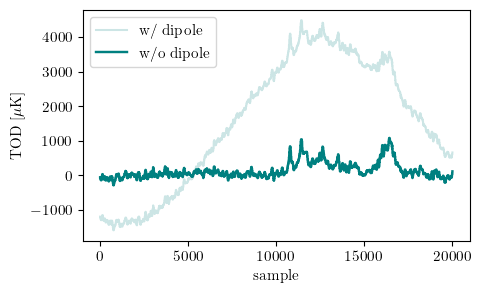

In [14]:
points=20000
color='teal'

plt.figure(figsize=(5, 3))
plt.plot(tod_dipole[:points],color=color,alpha=0.2,label='w/ dipole')
plt.plot(tod_noiseless[:points],color=color,linewidth=1.75,label='w/o dipole')
plt.legend()
plt.xlabel(r'sample')
plt.ylabel(r'TOD [$\mu$K]')
plt.savefig('dipole_TOD.pdf', bbox_inches = 'tight')
plt.show()

## Rough time requirements

As a reference, we print the time it took to simulate the TOD in the three cases we just considered: without noise and dipole, with noise (but no dipole) and with dipole (but no noise). All three TOD are simulated for a single detector with $f_\text{samp}=19.1\,\mathrm{Hz}$ taking data for 7 days. Without computing the dipole, the code takes around 18 seconds to run. When including the dipole the running time increases substantially (around 140 seconds).

In [15]:
print(time_noiseless)
print(time_noisy)
print(time_dipole)

17.47252607345581
17.770275354385376
140.69667196273804
